In [1]:
import os
import umap
import h5py
import torch
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from torch import nn
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr # Pearson cor

In [2]:
# custom 
import common.engines as engines 
import common.plotting as plotting 
import common.dataprocessing as dataprocessing


# Travail Pratique 6 : Introduction au benchmarking de réseaux de neurones artificiels sur des données transcriptomiques de cancers.
### Important: prière d'exécuter les cellules dans l'ordre ou redémarrer le noyau :) 
## 0. Introduction à git et préparation des données.


In [100]:
datasets = dataprocessing.load_datasets()

In [111]:
datasetname = "TCGA"
tpm_data = datasets[datasetname].data
genes = datasets[datasetname].samples
labels = datasets[datasetname].labels
samples = datasets[datasetname].genes

In [114]:
samples.shape

(10346,)

## I. Visualisation avec UMAP

In [102]:
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)

In [103]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =10, n_epochs = 1000).fit(X_train)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Thu Dec  7 15:26:12 2023 Construct fuzzy simplicial set
Thu Dec  7 15:26:12 2023 Finding Nearest Neighbors
Thu Dec  7 15:26:12 2023 Building RP forest with 10 trees
Thu Dec  7 15:26:17 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Thu Dec  7 15:26:31 2023 Finished Nearest Neighbor Search
Thu Dec  7 15:26:33 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec  7 15:26:57 2023 Finished embedding


In [104]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Thu Dec  7 15:26:59 2023 Worst tree score: 0.60778154
Thu Dec  7 15:26:59 2023 Mean tree score: 0.62966409
Thu Dec  7 15:26:59 2023 Best tree score: 0.64330594
Thu Dec  7 15:27:02 2023 Forward diversification reduced edges from 82760 to 34386
Thu Dec  7 15:27:06 2023 Reverse diversification reduced edges from 34386 to 34386
Thu Dec  7 15:27:09 2023 Degree pruning reduced edges from 35770 to 35670
Thu Dec  7 15:27:09 2023 Resorting data and graph based on tree order
Thu Dec  7 15:27:09 2023 Building and compiling search function


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


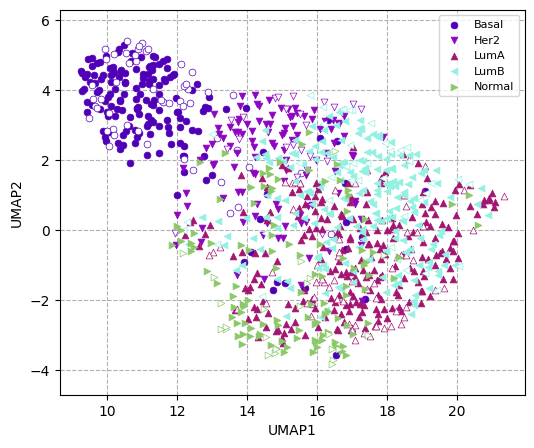

In [48]:
plotting.plot_umap(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s = 24)

## II. Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur. 
### II.1 Créez une fonction qui construit un modèle DNN selon la structure <code>encoder => bottleneck => decoder</code>


In [68]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [69]:
AE, encoder  = engines.auto_encoder(insize, insize, 2)
encoder(X_train).shape

torch.Size([818, 2])

### II.2 Lancez un entrainement de 1000 epochs et enregistrez la performance du modèle par epoch sous la forme de l'erreur et la correlation de Pearson sur l'ensemble de test et de train.

In [70]:
mm, trl, tstl, trc, tstc  = engines.train_auto_encoder(insize, 125, X_train, X_test, nepochs = 300, lr = 5 * 1e-4)


Loss 0 Train - loss : 0.152 - acc : 0.004 Test acc : 0.004
Loss 10 Train - loss : 0.148 - acc : 0.021 Test acc : 0.021
Loss 20 Train - loss : 0.145 - acc : 0.04 Test acc : 0.04
Loss 30 Train - loss : 0.139 - acc : 0.069 Test acc : 0.069
Loss 40 Train - loss : 0.123 - acc : 0.122 Test acc : 0.122
Loss 50 Train - loss : 0.086 - acc : 0.235 Test acc : 0.234
Loss 60 Train - loss : 0.046 - acc : 0.439 Test acc : 0.439
Loss 70 Train - loss : 0.029 - acc : 0.617 Test acc : 0.618
Loss 80 Train - loss : 0.027 - acc : 0.65 Test acc : 0.651
Loss 90 Train - loss : 0.027 - acc : 0.652 Test acc : 0.653
Loss 100 Train - loss : 0.026 - acc : 0.657 Test acc : 0.657
Loss 110 Train - loss : 0.026 - acc : 0.661 Test acc : 0.662
Loss 120 Train - loss : 0.026 - acc : 0.662 Test acc : 0.662
Loss 130 Train - loss : 0.026 - acc : 0.662 Test acc : 0.663
Loss 140 Train - loss : 0.026 - acc : 0.663 Test acc : 0.663
Loss 150 Train - loss : 0.026 - acc : 0.663 Test acc : 0.663
Loss 160 Train - loss : 0.026 - acc : 

### II.3 Produisez la courbe d'apprentissage de l'entrainement de ce réseau, c'est à dire la courbe de l'erreur sur le test et le train et la corrélation de Pearson selon les epochs. 

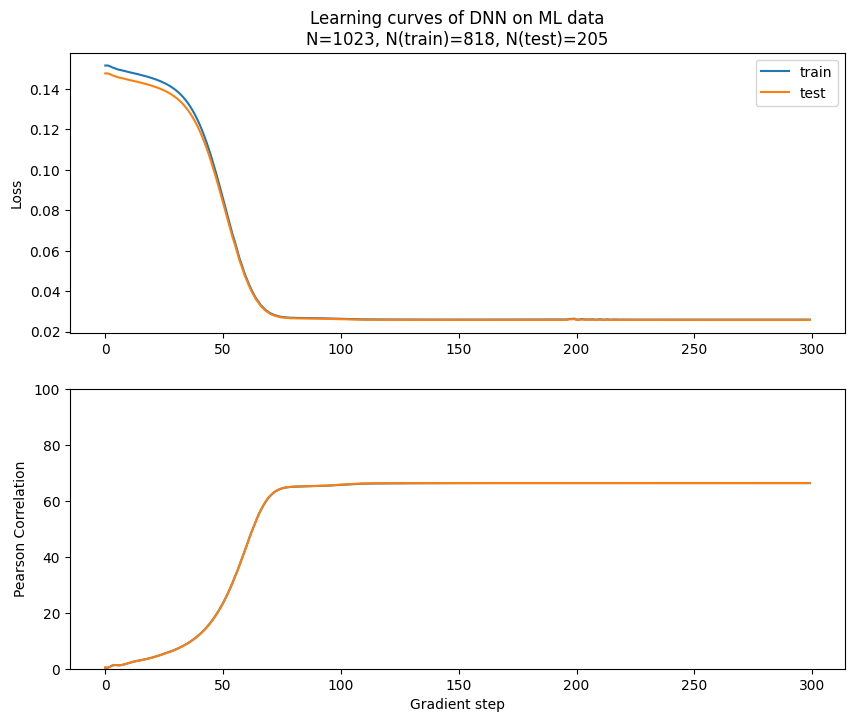

In [71]:
plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)

### II.4 Faites la visualisation de la corrélation sur les données de test prédites et vraies. <u>Rapportez votre résultat sous la forme d'un histogramme 2D avec des hexagones, l'échelle de la densité doit être rapportées.

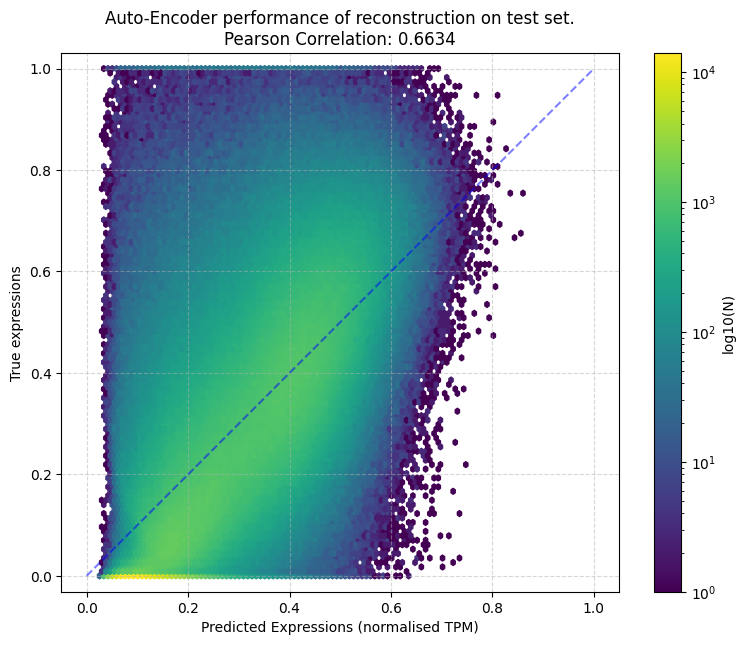

In [ ]:
plotting.plot_ae_performance(mm, X_test, dataset = datasetname)

## III. Variational Auto-Encoders (VAE) pour un gain de performance de reconstruction dans les problèmes de régression. (seance 2)

In [55]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [56]:
mm = engines.VariationalAutoencoder(insize, 2)

In [63]:
VAE, trl, tstl, trc, tstc = engines.train_variational_auto_encoder(insize, 125, X_train, X_test, nepochs = 300, printstep = 10, wd = 1e-3, lr = 1e-3)

Loss 0 Train - loss : 0.25 - acc : -0.006 Test acc : -0.006
Loss 10 Train - loss : 0.184 - acc : 0.058 Test acc : 0.057
Loss 20 Train - loss : 0.11 - acc : 0.163 Test acc : 0.163
Loss 30 Train - loss : 0.077 - acc : 0.283 Test acc : 0.281
Loss 40 Train - loss : 0.047 - acc : 0.434 Test acc : 0.431
Loss 50 Train - loss : 0.031 - acc : 0.596 Test acc : 0.593
Loss 60 Train - loss : 0.027 - acc : 0.65 Test acc : 0.649
Loss 70 Train - loss : 0.026 - acc : 0.653 Test acc : 0.651
Loss 80 Train - loss : 0.026 - acc : 0.659 Test acc : 0.657
Loss 90 Train - loss : 0.026 - acc : 0.661 Test acc : 0.66
Loss 100 Train - loss : 0.026 - acc : 0.662 Test acc : 0.661
Loss 110 Train - loss : 0.026 - acc : 0.663 Test acc : 0.661
Loss 120 Train - loss : 0.026 - acc : 0.663 Test acc : 0.662
Loss 130 Train - loss : 0.026 - acc : 0.663 Test acc : 0.662
Loss 140 Train - loss : 0.026 - acc : 0.663 Test acc : 0.662
Loss 150 Train - loss : 0.026 - acc : 0.663 Test acc : 0.662
Loss 160 Train - loss : 0.026 - acc :

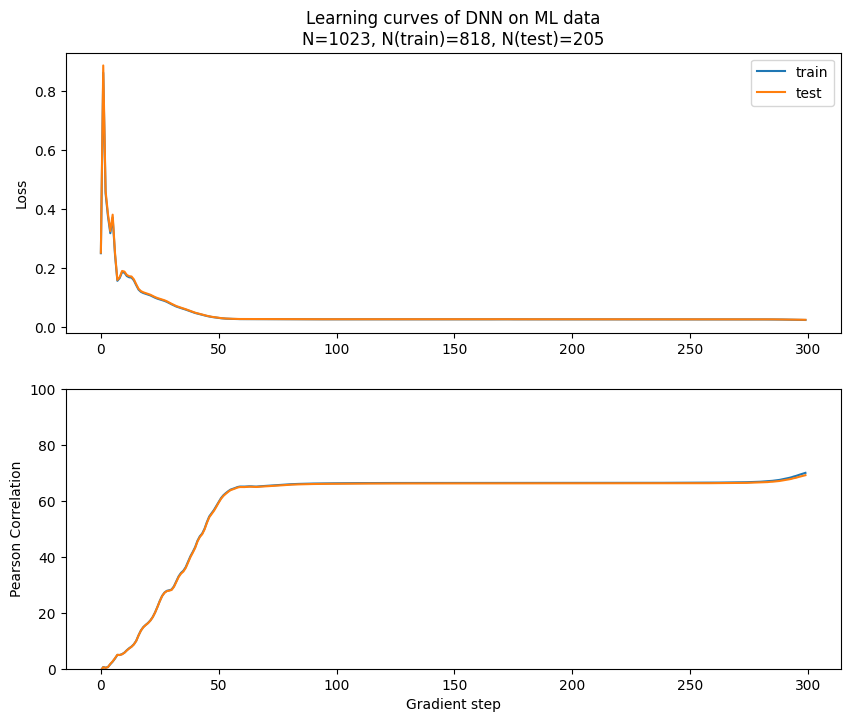

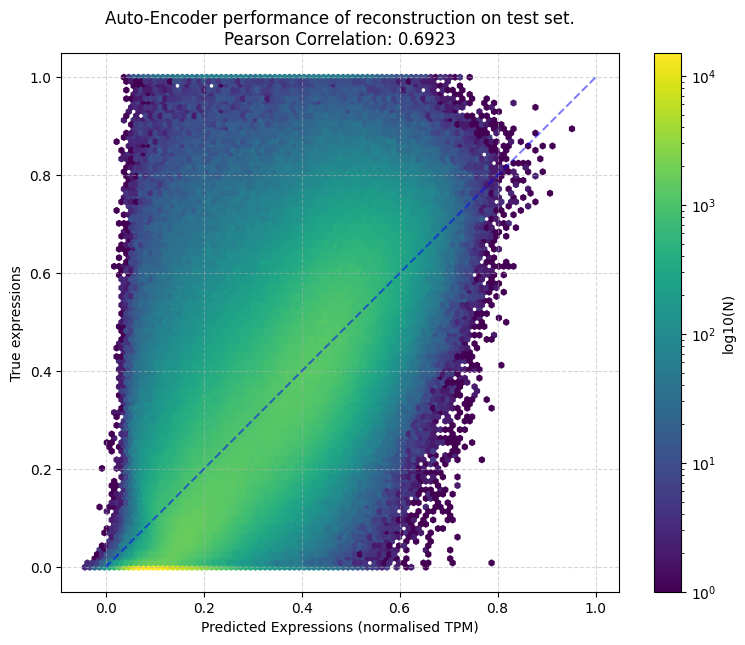

In [ ]:
plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)
plotting.plot_ae_performance(VAE, X_test, modeltype ="VAE", dataset = datasetname)

## IV. UMAP supervise

In [65]:
lblenc = LabelEncoder()
lblenc.fit(labels)
Y = lblenc.transform(labels)
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, Y, test_size = 0.2)
mapper = umap.UMAP(verbose = 1, n_components = 2, min_dist=1., 
    n_neighbors =5, n_epochs = 1000).fit(X_train,  y = Y_train)

UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=5, verbose=1)
Thu Dec  7 13:31:27 2023 Construct fuzzy simplicial set
Thu Dec  7 13:31:28 2023 Finding Nearest Neighbors
Thu Dec  7 13:31:28 2023 Finished Nearest Neighbor Search
Thu Dec  7 13:31:28 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec  7 13:31:31 2023 Finished embedding


In [66]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


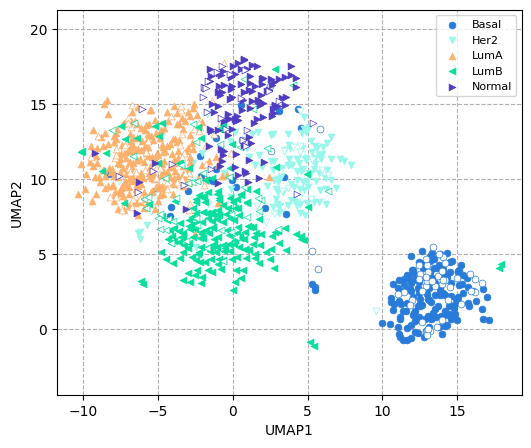

In [67]:
plotting.plot_umap(X_tr_umap, X_tst_umap, lblenc.inverse_transform(Y_train), lblenc.inverse_transform(Y_test), labels, s = 24)

# Projets : 
## Projet 1 : Régression et classification, quelle méthode utiliser et pourquoi?
### A. Testez les modèles suivants SVM, RF, Logistic, DNN pour la classification des sous-types moléculaires de BRCA, LAML, TALL.
### B. Testez les modèles suivants Auto-Encodeurs, VAE, RF, SVM, et la régression logistique pour la prédiction de l'expression de tous les gènes des jeux de données. Quels sont les paramètres utilisés? Répétez les expériences 10 fois et rapportez la moyenne et l'écart type des performances sur le test. Rapportez les temps de calculs sur CPU.
## Projet 2 : Hyper-paramétrisation et comparaison des performances des auto-encodeurs et des VAE pour la régression sur de vraies données transcriptomiques des cancers.
### A. Investiguer la l2, la taille du bottleneck. faire varier taille reste réseau. Quels sont les paramètres idéaux? Quelle est la taille de bottleneck idéale? Quels sont les paramètres sensibles?
### B. Comparaison des performances entre les méthodes VAE vs AE vs UMAP suivants TCGA, TCGA-BRCA, Leucegene-AML, TALL. Quelle méthode fonctionne le mieux et pourquoi?
## Projet 3 : Création de jeux de données transcriptomiques synthétiques et sur des données transcriptomiques chimériques
### A. Création d'un jeu de données synthétiques. Créez deux jeux de données synthétiques permettant de comprendre les forces et les faiblesses de chaque méthode. Comparaison des performances entre les méthodes pour la classification moléculaires et la régression. Quelle méthode fonctionne le mieux et pourquoi?
### B. Montez un protocole experimental pour créer un jeu de données synthétique en combinant deux sous-groupes de TCGA avec une tâche prédictive associée et testez les architectures proposées. Qu'en concluez-vous?

In [75]:
datasets["TCGA"].data

array([[2.1380138 , 1.6472441 , 2.4257395 , ..., 1.5517805 , 0.05514891,
        1.5976514 ],
       [0.34283704, 1.1426053 , 1.0648696 , ..., 0.9368906 , 2.3453155 ,
        1.2062347 ],
       [2.526551  , 0.9517891 , 1.5807666 , ..., 0.5234863 , 0.0991625 ,
        1.7828873 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.1119142 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.1052921 ,
        0.        ],
       [0.92262685, 0.8765296 , 0.99977845, ..., 1.4316387 , 1.0555313 ,
        1.033291  ]], dtype=float32)

In [77]:
np.unique(datasets["TCGA"].labels)

array(['TCGA-ACC', 'TCGA-BLCA', 'TCGA-BRCA', 'TCGA-CESC', 'TCGA-CHOL',
       'TCGA-COAD', 'TCGA-DLBC', 'TCGA-ESCA', 'TCGA-GBM', 'TCGA-HNSC',
       'TCGA-KICH', 'TCGA-KIRC', 'TCGA-KIRP', 'TCGA-LAML', 'TCGA-LGG',
       'TCGA-LIHC', 'TCGA-LUAD', 'TCGA-LUSC', 'TCGA-MESO', 'TCGA-OV',
       'TCGA-PAAD', 'TCGA-PCPG', 'TCGA-PRAD', 'TCGA-READ', 'TCGA-SARC',
       'TCGA-SKCM', 'TCGA-STAD', 'TCGA-TGCT', 'TCGA-THCA', 'TCGA-THYM',
       'TCGA-UCEC', 'TCGA-UCS', 'TCGA-UVM'], dtype='<U9')

In [94]:
keep = [i for (i,l) in enumerate(datasets["TCGA"].labels) if l in ['TCGA-LUAD', 'TCGA-LUSC'] ]
samples = np.array(datasets["TCGA"].samples, dtype = str)[keep]
tpm_data = datasets["TCGA"].data[:,keep]
labels = np.array(datasets["TCGA"].labels, dtype = str)[keep]

[]

In [95]:
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)

In [96]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =10, n_epochs = 1000).fit(X_train)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Thu Dec  7 15:12:32 2023 Construct fuzzy simplicial set
Thu Dec  7 15:12:34 2023 Finding Nearest Neighbors
Thu Dec  7 15:12:34 2023 Finished Nearest Neighbor Search
Thu Dec  7 15:12:34 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec  7 15:12:38 2023 Finished embedding


In [98]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


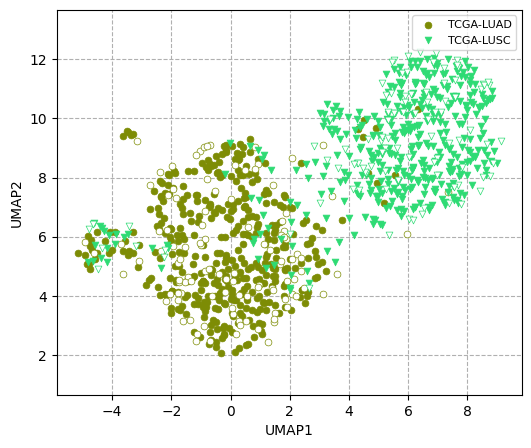

In [ ]:
plotting.plot_umap(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s = 24)

## Projet 4 : Développement d'un algorithme de réduction de dimensionnalité de projection en coordonnées sphériques pour une visualisation plus représentative.
### A. Proposez une approche qui permet une telle visualisation.
### B. Trouvez une métrique de distance intra-groupe, et extra-groupe qui permet de comparer ces visualisaitons avec les visualisations classiques. Que vient apporter cette méthode?

In [108]:
phi, psi =  (X_tr_umap / (2 * np.pi)).T


In [109]:
x,y, z= np.sin(phi) * np.cos(psi), np.sin(phi) * np.sin(psi), np.cos(phi)

In [119]:
labels

array(['TCGA-LIHC', 'TCGA-PRAD', 'TCGA-READ', ..., 'TCGA-LGG',
       'TCGA-LAML', 'TCGA-THCA'], dtype='<U9')

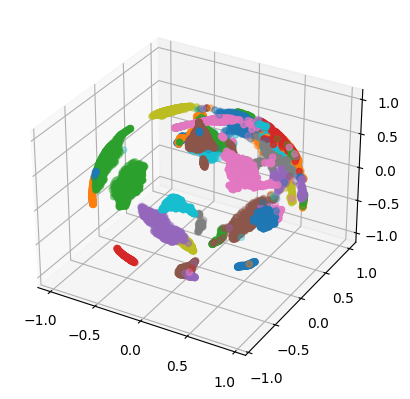

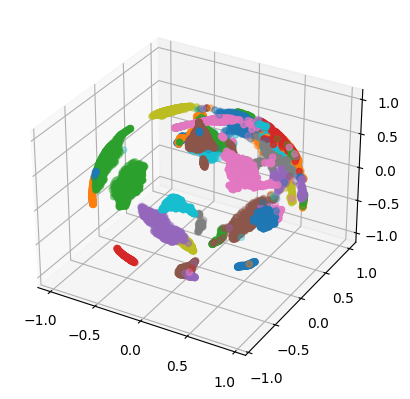

In [128]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for subtype in np.unique(labels):
    group = Y_train == subtype
    ax.scatter(x[group], y[group], z[group], label = subtype)
fig


## Projet 5 : Comparaison des performances entre les méthodes linéaires vs méthodes non-linéaires pour la prédiction sur de vraies données transcriptomiques des cancers de TCGA.
### A. Pour la classification moléculaires entre la régression linéaire et un DNN, quelle méthode fonctionne le mieux et pourquoi?
### B. Pour la régression entre la régression linéaire et un Auto-Encodeur, quelle méthode fonctionne le mieux et pourquoi?
### C: Auto-Encodeur Lineaire vs PCA 

In [48]:
datasetname = "LAML"
tpm_data = datasets[datasetname].data
genes = datasets[datasetname].genes
labels = datasets[datasetname].labels
samples = datasets[datasetname].samples

In [49]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(tpm_data.T), Y, test_size = 0.2)
insize = X_train.shape[1]

In [62]:
### fonction d'initialisation du reseau
def linear_auto_encoder(insize, outsize, bnsize, width=500):
    model = nn.Sequential(
    nn.Linear(insize,width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, bnsize, bias = False), 
    nn.Linear(bnsize, width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, outsize, bias = False))
    return model, model[0:3]


def train_linear_auto_encoder(insize, bnsize, X_train, X_test, nepochs = 100, printstep=10, wd = 1e-3, lr = 0.0001):
    DNN, encoder = linear_auto_encoder(insize, insize, bnsize )
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr)
    tr_losses, tst_losses, tr_accs, tst_accs = [],[],[],[]
    for i in range(nepochs):
        optimizer.zero_grad() # required
        y_tr_out = DNN(X_train) # feed forward
        y_tst_out = DNN(X_test)
        tr_loss = nn.functional.mse_loss(y_tr_out, X_train) # loss computation
        tst_loss = nn.functional.mse_loss(y_tst_out, X_test) # Softmax -> NLL
        
        tr_acc = pearsonr(y_tr_out.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic # Pearson corr. coeff
        tst_acc = pearsonr(y_tst_out.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic
            
        if i % printstep == 0 or i+1 == nepochs :
            print(f"Loss {i} Train - loss : {round(float(tr_loss),3)} - acc : {round(float(tr_acc),3)} Test acc : {round(tst_acc,3)}")
        tr_loss.backward() # back prop
        optimizer.step() # optimizer update
        [tr_losses.append(float(tr_loss)), tst_losses.append(float(tst_loss)), tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
    return DNN, np.array(tr_losses), np.array(tst_losses), np.array(tr_accs), np.array(tst_accs)


In [63]:
LAE, trl, tstl, trc, tstc = train_linear_auto_encoder(insize, 2, X_train, X_test, nepochs = 100, lr = 1e-4)

Loss 0 Train - loss : 1.187 - acc : -0.002 Test acc : -0.001
Loss 10 Train - loss : 1.141 - acc : 0.116 Test acc : 0.116
Loss 20 Train - loss : 0.666 - acc : 0.434 Test acc : 0.431
Loss 30 Train - loss : 0.263 - acc : 0.77 Test acc : 0.767
Loss 40 Train - loss : 0.107 - acc : 0.906 Test acc : 0.903
Loss 50 Train - loss : 0.064 - acc : 0.942 Test acc : 0.939
Loss 60 Train - loss : 0.051 - acc : 0.954 Test acc : 0.952
Loss 70 Train - loss : 0.047 - acc : 0.958 Test acc : 0.956
Loss 80 Train - loss : 0.045 - acc : 0.959 Test acc : 0.957
Loss 90 Train - loss : 0.045 - acc : 0.96 Test acc : 0.957
Loss 99 Train - loss : 0.045 - acc : 0.96 Test acc : 0.957


In [64]:
LAE_X_train = LAE[0:3](X_train).detach().numpy()
LAE_X_test = LAE[0:3](X_test).detach().numpy()

In [65]:
pca = PCA(n_components=2)
pca.fit(X_train)
PCA_X_train = pca.transform(X_train)
PCA_X_test = pca.transform(X_test)

In [66]:
y_tr_labs = lblbin.inverse_transform(Y_train.detach().numpy())
y_tst_labs = lblbin.inverse_transform(Y_test.detach().numpy())

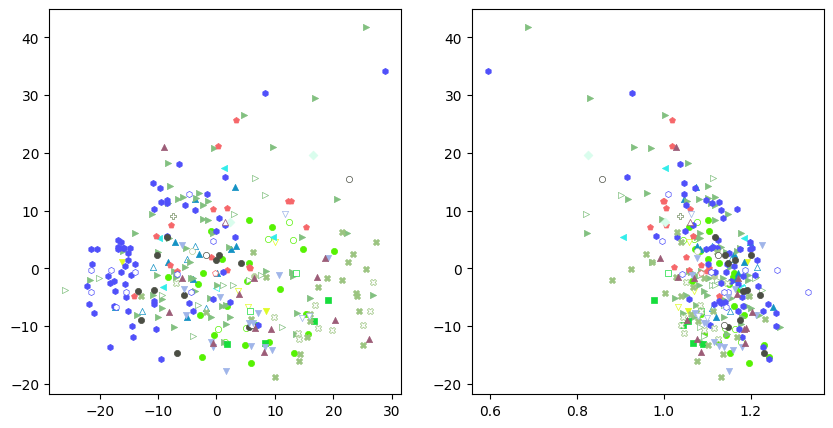

In [67]:
def random_color_generator():
    r = random.randint(0, 255)/256
    g = random.randint(0, 255)/256
    b = random.randint(0, 255)/256
    return (r, g, b)
# comparison 
fig, axes = plt.subplots(ncols = 2, figsize = (10,5))
s = 20
markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])
colors_by_ctype = [random_color_generator() for  i in range(len(np.unique(labels)))]
for (i,lbl) in enumerate(np.unique(labels)):
    axes[0].scatter(PCA_X_train[y_tr_labs ==lbl,0], 
                PCA_X_train[y_tr_labs ==lbl,1], 
                s = s, color = colors_by_ctype[i], linewidth = 0.5, marker=markers_[i], label = lbl)
    axes[0].scatter(PCA_X_test[ y_tst_labs ==lbl,0], 
            PCA_X_test[y_tst_labs==lbl,1], 
            s = s, edgecolors = colors_by_ctype[i], color ="white", linewidth = 0.5, marker=markers_[i])
    axes[1].scatter(LAE_X_train[y_tr_labs ==lbl,0], 
                PCA_X_train[y_tr_labs ==lbl,1], 
                s = s, color = colors_by_ctype[i], linewidth = 0.5, marker=markers_[i], label = lbl)
    axes[1].scatter(LAE_X_test[ y_tst_labs ==lbl,0], 
            PCA_X_test[y_tst_labs==lbl,1], 
            s = s, edgecolors = colors_by_ctype[i], color ="white", linewidth = 0.5, marker=markers_[i])